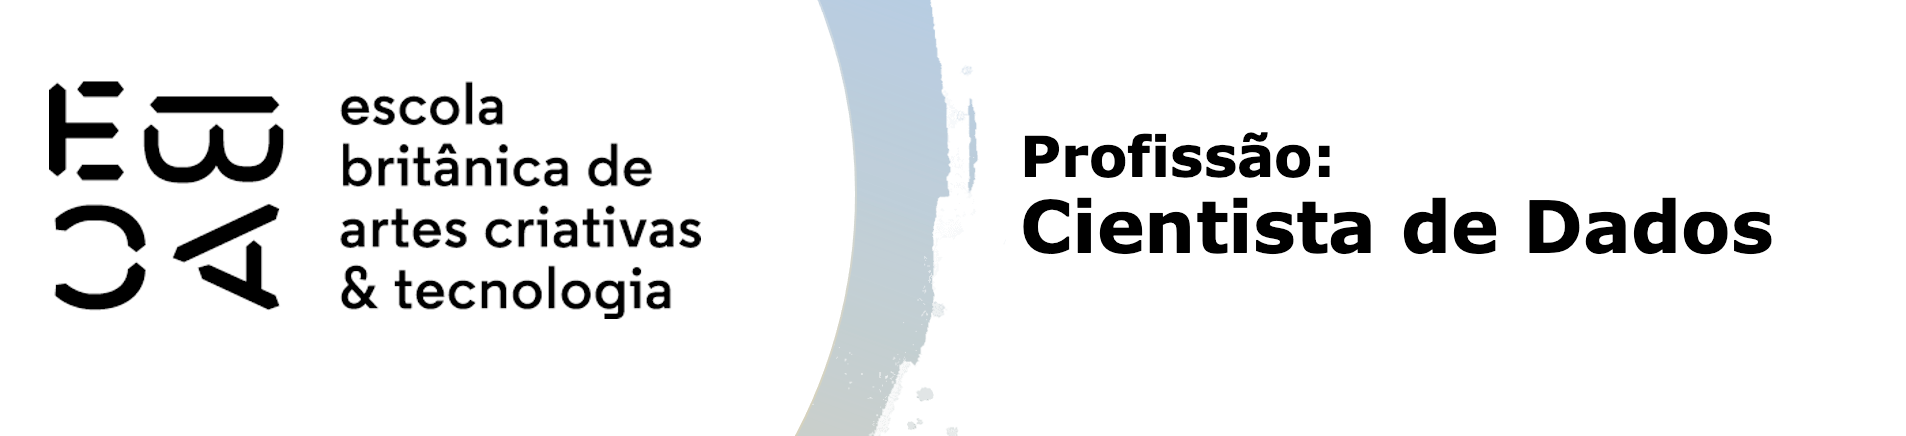

In [1]:
#carregando pacotes
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#carregando df
df = pd.read_pickle('base_nfp.pkl')
df2 = df.copy()
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [3]:
#verificando dados ausentes
df.isna().sum()

CNPJ emit.               0
Emitente                 0
No.                      0
Data Emissão             0
Valor NF                 0
Data Registro            0
Créditos                 0
Situação do Crédito      0
Ano                      0
Semestre                 0
Retorno                980
flag_credito             0
categoria                0
dtype: int64

In [4]:
#preenchendo valores ausentes de retorno com a média
df.Retorno = df.Retorno.fillna(df.Retorno.mean())

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [5]:
#verificando dtype das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              187646 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No.,187646.0,809871.044920,6.326243e+06,1.0,20318.25,54604.50,137446.500000,444457509.0
Valor NF,187646.0,132.505844,1.617621e+03,0.0,16.90,38.88,101.480000,562500.0
Créditos,187646.0,8.032197,3.192022e+01,0.0,0.00,0.00,0.850000,290.9
Ano,187646.0,2019.185738,1.457752e+00,2017.0,2018.00,2019.00,2020.000000,2021.0
Semestre,187646.0,1.572722,4.946846e-01,1.0,1.00,2.00,2.000000,2.0
Retorno,187646.0,0.112481,2.235920e+00,0.0,0.00,0.00,0.026936,941.6
flag_credito,187646.0,0.451051,4.975996e-01,0.0,0.00,0.00,1.000000,1.0


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [7]:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [8]:
df['dia_da_semana'] = df['Data Emissão'].dt.dayofweek

In [9]:
df['dia_da_semana'].unique()

array([4, 3, 2, 1, 0, 6, 5], dtype=int64)

In [10]:
df['fim_de_semana'] = df['Data Emissão'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

In [11]:
df['dia_do_mes'] = df['Data Emissão'].dt.day

In [12]:
df['mes'] = df['Data Emissão'].dt.month

In [13]:
df['ano'] = df['Data Emissão'].dt.year

In [14]:
df['trimestre'] = df['Data Emissão'].dt.quarter

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [15]:
df['Créditos'] = df['Créditos'].apply(lambda x: 0 if x == 0 else 1)

In [16]:
df.columns

Index(['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria', 'dia_da_semana',
       'fim_de_semana', 'dia_do_mes', 'mes', 'ano', 'trimestre'],
      dtype='object')

In [17]:
df_ = df.copy()

In [18]:
df.drop(columns=['CNPJ emit.', 'Emitente', 'No.', 'ano','Situação do Crédito','Data Emissão', 'Data Registro','categoria'], inplace=True)
metadados = pd.DataFrame({'dtype':df.dtypes})
metadados

,dtype
Valor NF,float64
Créditos,int64
Ano,int64
Semestre,int64
Retorno,float64
flag_credito,int64
dia_da_semana,int64
fim_de_semana,int64
dia_do_mes,int64
mes,int64


In [19]:
metadados['papel'] = 'covariavel'
metadados.loc['Créditos','papel'] = 'resposta'
metadados['nunique'] = df.nunique()
metadados

,dtype,papel,nunique
Valor NF,float64,covariavel,33658
Créditos,int64,resposta,2
Ano,int64,covariavel,5
Semestre,int64,covariavel,2
Retorno,float64,covariavel,60203
flag_credito,int64,covariavel,2
dia_da_semana,int64,covariavel,7
fim_de_semana,int64,covariavel,2
dia_do_mes,int64,covariavel,31
mes,int64,covariavel,12


In [20]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [21]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>5):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.Créditos)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.Créditos)
    
metadados

C:\Users\felip\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\felip\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dtype,papel,nunique,IV
Valor NF,float64,covariavel,33658,0.056695
Créditos,int64,resposta,2,NaN
Ano,int64,covariavel,5,0.041651
Semestre,int64,covariavel,2,0.001258
Retorno,float64,covariavel,60203,inf
flag_credito,int64,covariavel,2,inf
dia_da_semana,int64,covariavel,7,0.006874
fim_de_semana,int64,covariavel,2,0.004346
dia_do_mes,int64,covariavel,31,0.001223
mes,int64,covariavel,12,0.006191


In [22]:
tab = pd.crosstab(df_.categoria,df_.Créditos,margins=True,margins_name='total')
rótulo_evento = tab.columns[0]
rótulo_nao_evento = tab.columns[1]

tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab

Créditos,0,1,total,pct_evento,pct_nao_evento,woe
categoria,,,,,,
Alimentos,2092,12868,14960,0.020309,0.152036,-2.013046
Auto posto,3418,271,3689,0.033182,0.003202,2.338269
Construção,18425,13811,32236,0.178870,0.163177,0.091820
Farmácia,10054,4886,14940,0.097604,0.057728,0.525173
Mercado,22887,19808,42695,0.222187,0.234032,-0.051940
Restaurantes,22631,17118,39749,0.219701,0.202250,0.082767
Varejo,4869,1035,5904,0.047268,0.012229,1.352064
Vestuário,1813,1799,3612,0.017601,0.021255,-0.188671
não definido,16819,13042,29861,0.163279,0.154092,0.057911


In [23]:
tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
print(tab.iv_parcial.sum())
tab

0.408312792227301


Créditos,0,1,total,pct_evento,pct_nao_evento,woe,iv_parcial
categoria,,,,,,,
Alimentos,2092,12868,14960,0.020309,0.152036,-2.013046,0.265172
Auto posto,3418,271,3689,0.033182,0.003202,2.338269,0.070101
Construção,18425,13811,32236,0.178870,0.163177,0.091820,0.001441
Farmácia,10054,4886,14940,0.097604,0.057728,0.525173,0.020942
Mercado,22887,19808,42695,0.222187,0.234032,-0.051940,0.000615
Restaurantes,22631,17118,39749,0.219701,0.202250,0.082767,0.001444
Varejo,4869,1035,5904,0.047268,0.012229,1.352064,0.047376
Vestuário,1813,1799,3612,0.017601,0.021255,-0.188671,0.000690
não definido,16819,13042,29861,0.163279,0.154092,0.057911,0.000532


In [24]:
iv_categoria = ((tab.pct_evento - tab.pct_nao_evento)*tab.woe).sum()
iv_categoria

0.408312792227301

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### O valor da nf apresente IV até muito alto, sendo necessário desconfiar, o ano apresente um IV forte e a categoria também, a variável trimestre moderado, e as demais sem poder de discriminação


### Sim, o número de categorias em que uma variável contínua é categorizada pode ter uma influência na métrica IV (Valor da Informação). Geralmente, ao categorizar uma variável contínua em um maior número de categorias, você pode obter um valor de IV mais alto. No entanto, essa relação nem sempre é linear e pode depender da natureza dos dados e do relacionamento entre a variável preditora e a variável de resposta. Mas temos que nos atentar ao overfiting

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [25]:
df.columns

Index(['Valor NF', 'Créditos', 'Ano', 'Semestre', 'Retorno', 'flag_credito',
       'dia_da_semana', 'fim_de_semana', 'dia_do_mes', 'mes', 'trimestre'],
      dtype='object')

In [26]:
notas_por_trimestre = df.groupby('trimestre')['Valor NF'].count()

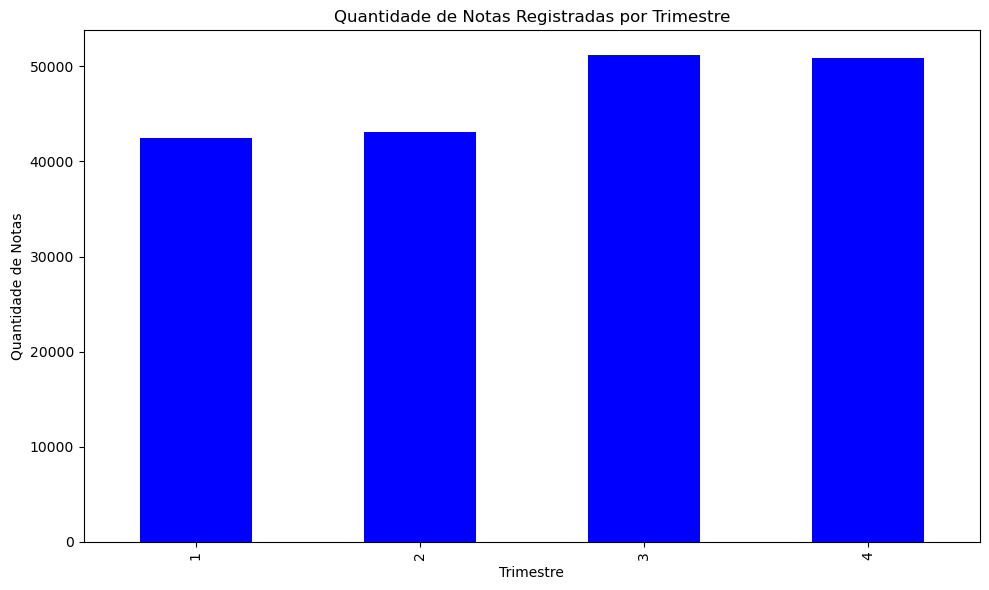

In [27]:
plt.figure(figsize=(10, 6))
notas_por_trimestre.plot(kind='bar', color='blue')
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(range(len(notas_por_trimestre)), ['1', '2', '3', '4'])  # Mostrar apenas os números 1, 2, 3 e 4 no eixo x
plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [28]:
categ_tempo = df_[['Data Emissão','categoria','Créditos']]
categ_tempo

,Data Emissão,categoria,Créditos
0,2017-06-30,Mercado,0
1,2017-06-30,Auto posto,0
2,2017-06-30,Restaurantes,1
3,2017-06-30,Restaurantes,1
4,2017-06-30,Restaurantes,1
...,...,...,...
187641,2021-01-07,não definido,0
187642,2021-01-07,Mercado,0
187643,2021-01-07,Farmácia,0
187644,2021-01-07,Mercado,0


In [29]:
# Usando pd.get_dummies para criar variáveis dummies
dummies = pd.get_dummies(categ_tempo['Créditos'])

# Concatenando as variáveis dummies no DataFrame original
categ_tempo = pd.concat([categ_tempo, dummies], axis=1)
categ_tempo

,Data Emissão,categoria,Créditos,0,1
0,2017-06-30,Mercado,0,1,0
1,2017-06-30,Auto posto,0,1,0
2,2017-06-30,Restaurantes,1,0,1
3,2017-06-30,Restaurantes,1,0,1
4,2017-06-30,Restaurantes,1,0,1
...,...,...,...,...,...
187641,2021-01-07,não definido,0,1,0
187642,2021-01-07,Mercado,0,1,0
187643,2021-01-07,Farmácia,0,1,0
187644,2021-01-07,Mercado,0,1,0


In [30]:
categ_tempo = categ_tempo.drop('Créditos',axis=1)
categ_tempo

,Data Emissão,categoria,0,1
0,2017-06-30,Mercado,1,0
1,2017-06-30,Auto posto,1,0
2,2017-06-30,Restaurantes,0,1
3,2017-06-30,Restaurantes,0,1
4,2017-06-30,Restaurantes,0,1
...,...,...,...,...
187641,2021-01-07,não definido,1,0
187642,2021-01-07,Mercado,1,0
187643,2021-01-07,Farmácia,1,0
187644,2021-01-07,Mercado,1,0


In [31]:
grupo = categ_tempo.groupby(['Data Emissão', 'categoria']).sum()
grupo

0     1
Data Emissão categoria               
2017-01-01   Auto posto     7.0   0.0
             Farmácia       1.0   1.0
2017-01-02   Alimentos      1.0  22.0
             Auto posto    17.0   0.0
             Construção    11.0   0.0
...                         ...   ...
2021-12-31   Mercado       23.0  15.0
             Restaurantes   2.0   2.0
             Varejo         2.0   0.0
             Vestuário      3.0   0.0
             não definido   5.0  11.0

[13040 rows x 2 columns]

In [32]:
grupo['N'] = grupo.sum(axis=1)
grupo['tx_evento'] = grupo[1]/grupo[0]

In [33]:
grupo

0     1     N  tx_evento
Data Emissão categoria                                
2017-01-01   Auto posto     7.0   0.0   7.0   0.000000
             Farmácia       1.0   1.0   2.0   1.000000
2017-01-02   Alimentos      1.0  22.0  23.0  22.000000
             Auto posto    17.0   0.0  17.0   0.000000
             Construção    11.0   0.0  11.0   0.000000
...                         ...   ...   ...        ...
2021-12-31   Mercado       23.0  15.0  38.0   0.652174
             Restaurantes   2.0   2.0   4.0   1.000000
             Varejo         2.0   0.0   2.0   0.000000
             Vestuário      3.0   0.0   3.0   0.000000
             não definido   5.0  11.0  16.0   2.200000

[13040 rows x 4 columns]

In [34]:
rotulo_ev, rotulo_nev = (1, 0)

grupo['pct_evento']     = grupo[rotulo_ev]/grupo[rotulo_ev].groupby(level=0).sum()
grupo['pct_nao_evento'] = grupo[rotulo_nev]/grupo[rotulo_nev].groupby(level=0).sum()
grupo['WOE'] = np.log(grupo.pct_evento/grupo.pct_nao_evento)
grupo.head()

C:\Users\felip\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0     1     N  tx_evento  pct_evento  \
Data Emissão categoria                                             
2017-01-01   Auto posto   7.0   0.0   7.0        0.0    0.000000   
             Farmácia     1.0   1.0   2.0        1.0    1.000000   
2017-01-02   Alimentos    1.0  22.0  23.0       22.0    0.236559   
             Auto posto  17.0   0.0  17.0        0.0    0.000000   
             Construção  11.0   0.0  11.0        0.0    0.000000   

                         pct_nao_evento       WOE  
Data Emissão categoria                             
2017-01-01   Auto posto           0.875      -inf  
             Farmácia             0.125  2.079442  
2017-01-02   Alimentos            0.008  3.386757  
             Auto posto           0.136      -inf  
             Construção           0.088      -inf

In [35]:
grupo.columns

Index([0, 1, 'N', 'tx_evento', 'pct_evento', 'pct_nao_evento', 'WOE'], dtype='object')

In [36]:
grupo_reset = grupo.reset_index()
grupo_reset

,Data Emissão,categoria,0,1,N,tx_evento,pct_evento,pct_nao_evento,WOE
0,2017-01-01,Auto posto,7.0,0.0,7.0,0.000000,0.000000,0.875000,-inf
1,2017-01-01,Farmácia,1.0,1.0,2.0,1.000000,1.000000,0.125000,2.079442
2,2017-01-02,Alimentos,1.0,22.0,23.0,22.000000,0.236559,0.008000,3.386757
3,2017-01-02,Auto posto,17.0,0.0,17.0,0.000000,0.000000,0.136000,-inf
4,2017-01-02,Construção,11.0,0.0,11.0,0.000000,0.000000,0.088000,-inf
...,...,...,...,...,...,...,...,...,...
13035,2021-12-31,Mercado,23.0,15.0,38.0,0.652174,0.333333,0.442308,-0.282863
13036,2021-12-31,Restaurantes,2.0,2.0,4.0,1.000000,0.044444,0.038462,0.144581
13037,2021-12-31,Varejo,2.0,0.0,2.0,0.000000,0.000000,0.038462,-inf
13038,2021-12-31,Vestuário,3.0,0.0,3.0,0.000000,0.000000,0.057692,-inf


In [37]:
grupo_sorted = grupo_reset.sort_values(['Data Emissão'])
grupo_sorted

,Data Emissão,categoria,0,1,N,tx_evento,pct_evento,pct_nao_evento,WOE
0,2017-01-01,Auto posto,7.0,0.0,7.0,0.000000,0.000000,0.875000,-inf
1,2017-01-01,Farmácia,1.0,1.0,2.0,1.000000,1.000000,0.125000,2.079442
2,2017-01-02,Alimentos,1.0,22.0,23.0,22.000000,0.236559,0.008000,3.386757
3,2017-01-02,Auto posto,17.0,0.0,17.0,0.000000,0.000000,0.136000,-inf
4,2017-01-02,Construção,11.0,0.0,11.0,0.000000,0.000000,0.088000,-inf
...,...,...,...,...,...,...,...,...,...
13034,2021-12-31,Farmácia,3.0,1.0,4.0,0.333333,0.022222,0.057692,-0.954031
13035,2021-12-31,Mercado,23.0,15.0,38.0,0.652174,0.333333,0.442308,-0.282863
13036,2021-12-31,Restaurantes,2.0,2.0,4.0,1.000000,0.044444,0.038462,0.144581
13037,2021-12-31,Varejo,2.0,0.0,2.0,0.000000,0.000000,0.038462,-inf


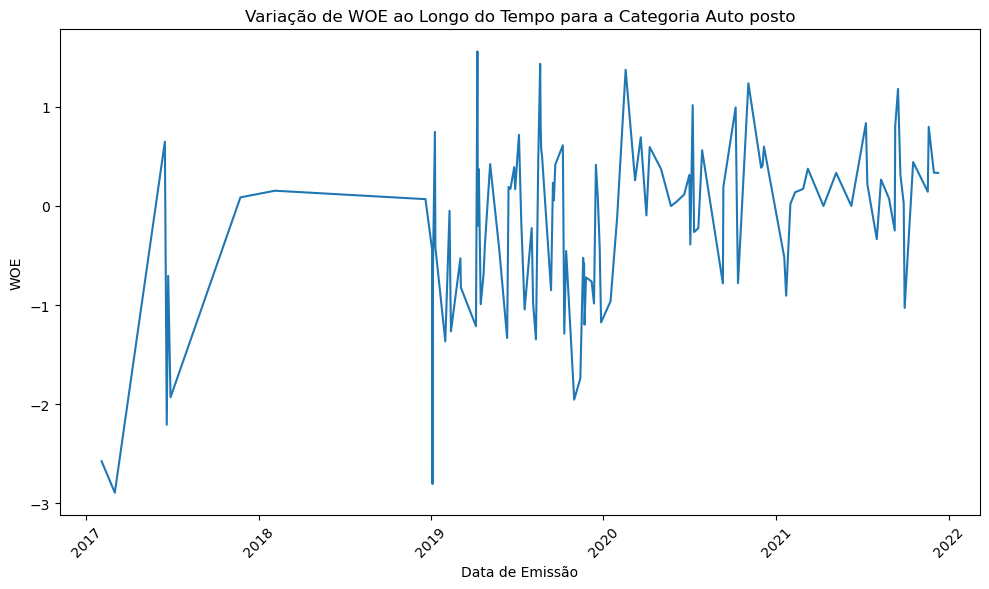

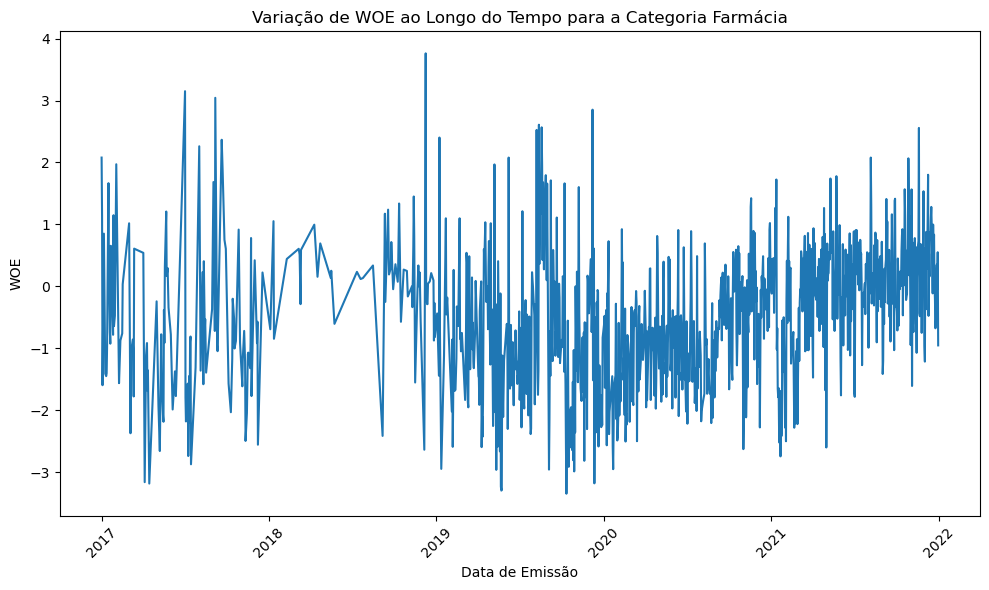

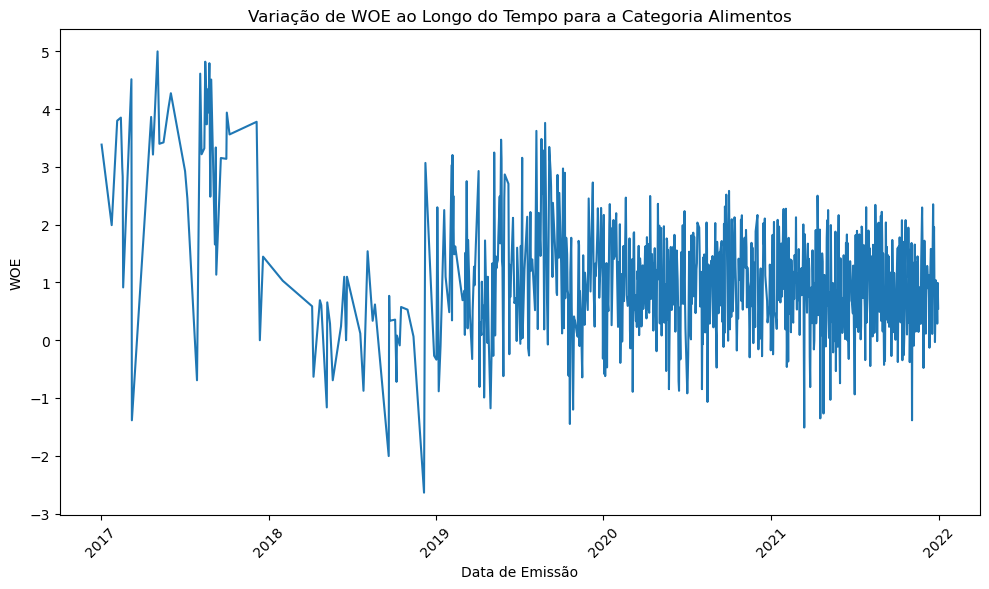

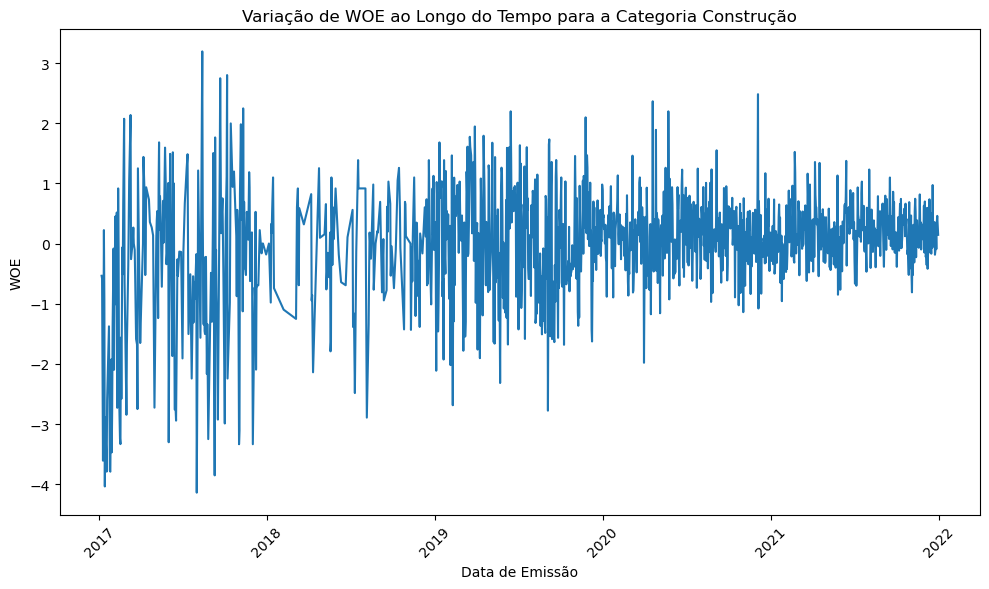

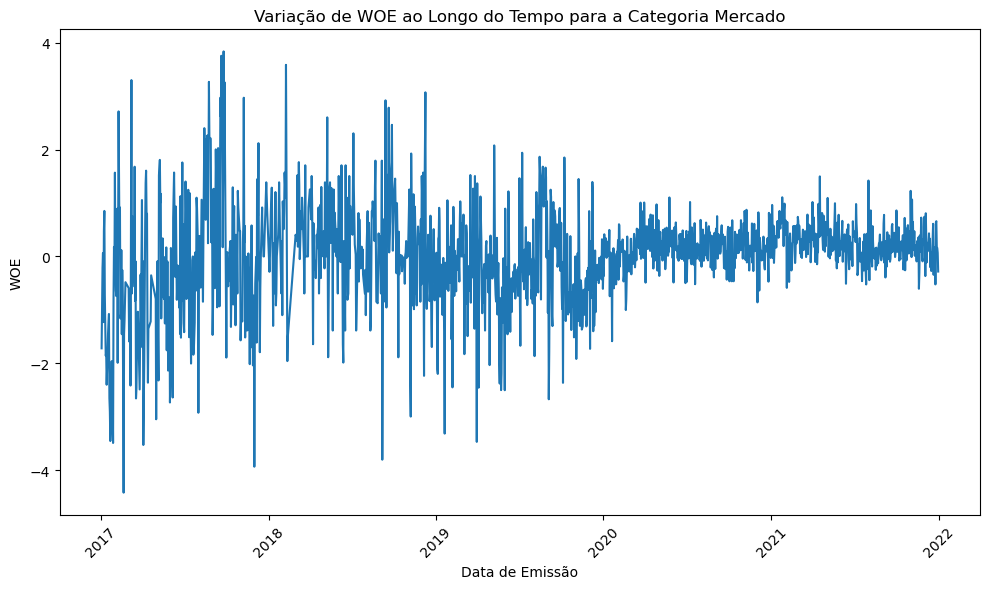

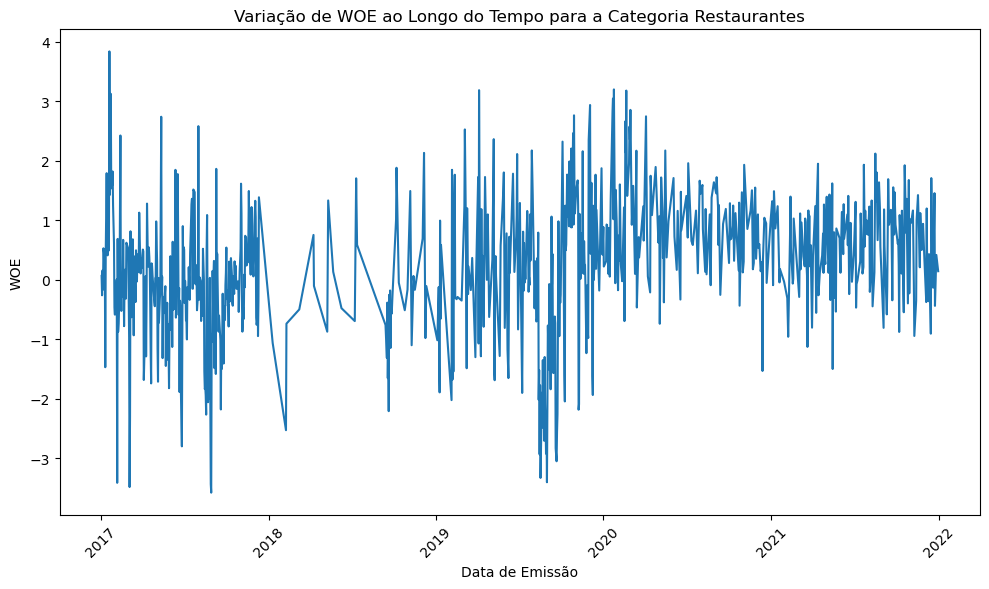

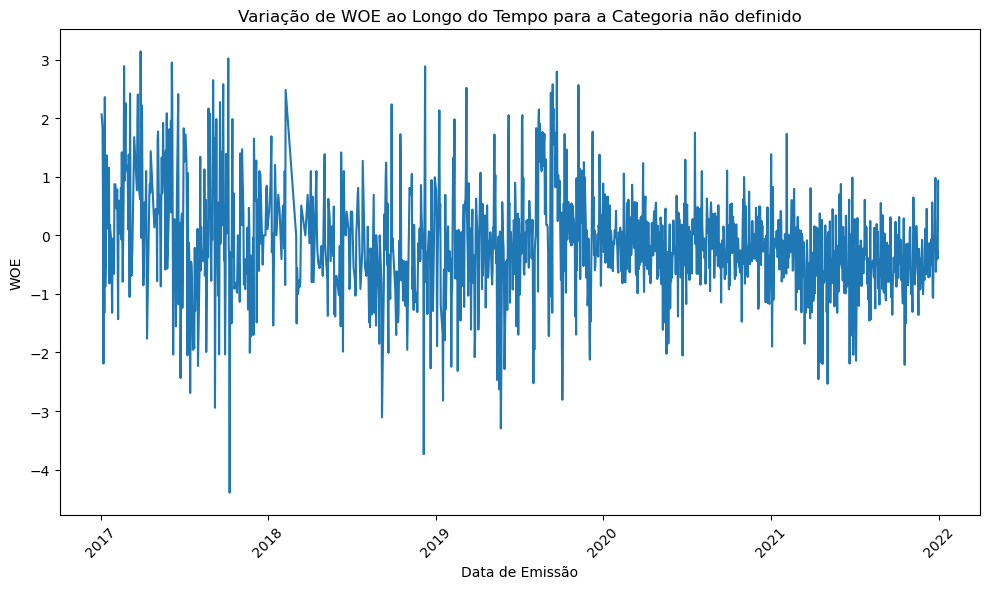

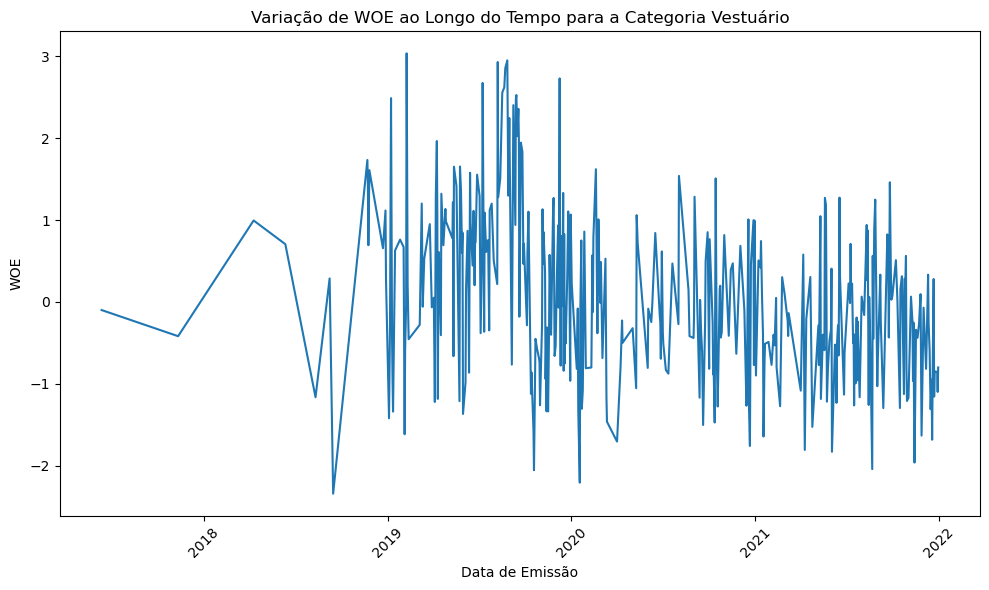

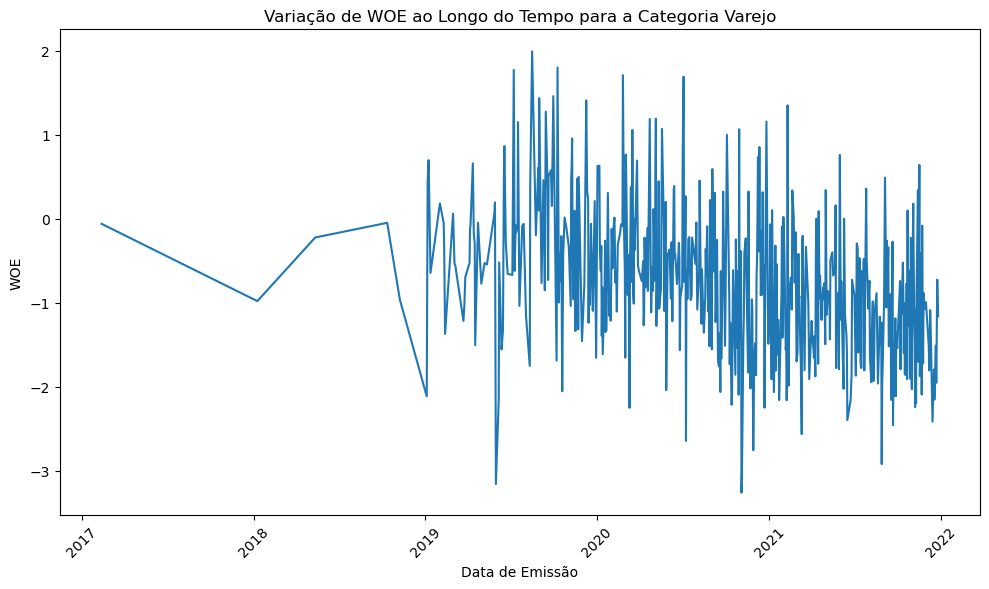

In [46]:
# Listar todas as categorias únicas
categorias_unicas = grupo_sorted['categoria'].unique()

# Iterar pelas categorias e criar um gráfico separado para cada uma
for categoria in categorias_unicas:
    df_categoria = grupo_sorted[grupo_sorted['categoria'] == categoria]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_categoria, x='Data Emissão', y='WOE')
    plt.title(f'Variação de WOE ao Longo do Tempo para a Categoria {categoria}')
    plt.xlabel('Data de Emissão')
    plt.ylabel('WOE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

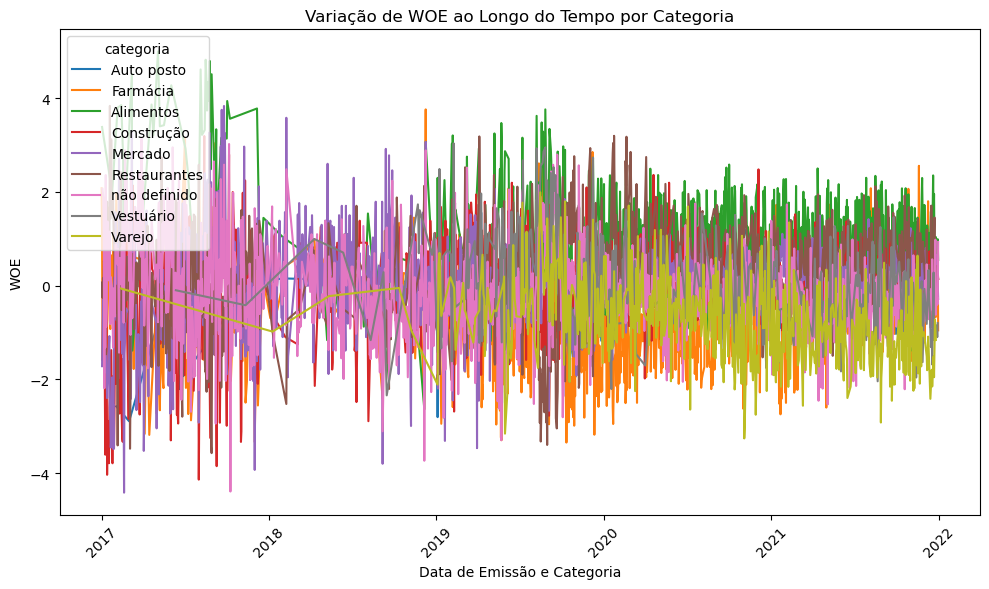

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grupo_sorted, x='Data Emissão', y='WOE', hue='categoria')
plt.title('Variação de WOE ao Longo do Tempo por Categoria')
plt.xlabel('Data de Emissão e Categoria')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
iv_categoria = ((grupo.pct_evento - grupo.pct_nao_evento)*grupo.WOE).groupby(level=0).sum();

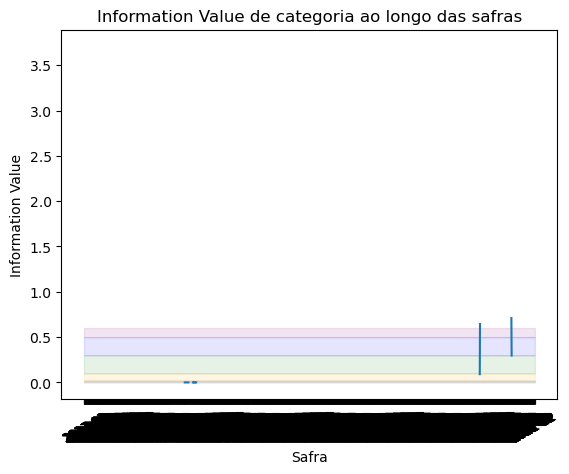

In [43]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
    labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de categoria ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")
    
plot_iv(iv_categoria)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

### Alimentos e Restaurantes tem maior proporção com retornos maiores que zero tendo dentre as categorias a maior estabilidade

### As demais tem momentos em que tem maior proporção com retornos maiores que 0 e momentos que estão menores do que 0